In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/")

In [ ]:
!cat ./drive/MyDrive/tensors/tensors.zip* > tensors.zip

In [ ]:
!unzip tensors.zip

Streaming output truncated to the last 5000 lines.
  inflating: tensors/data5499        
  inflating: tensors/data55          
  inflating: tensors/data550         
  inflating: tensors/data5500        
  inflating: tensors/data5501        
  inflating: tensors/data5502        
  inflating: tensors/data5503        
  inflating: tensors/data5504        
  inflating: tensors/data5505        
  inflating: tensors/data5506        
  inflating: tensors/data5507        
  inflating: tensors/data5508        
  inflating: tensors/data5509        
  inflating: tensors/data551         
  inflating: tensors/data5510        
  inflating: tensors/data5511        
  inflating: tensors/data5512        
  inflating: tensors/data5513        
  inflating: tensors/data5514        
  inflating: tensors/data5515        
  inflating: tensors/data5516        
  inflating: tensors/data5517        
  inflating: tensors/data5518        
  inflating: tensors/data5519        
  inflating: tensors/data552         

In [ ]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision
import gc

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###
from torchsummary import summary
from skimage.transform import resize
from skimage import color
from skimage import io
import re
from google.colab import files
import wandb



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Utils functions

In [ ]:
def lab_to_rgb(img_l, img_ab):
    """
    Convert a pair of numpy arrays (l channel and ab channels) into an rgb image
    :param img_l:
    :return:
    """
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50))
    lab[:, :, 1:] = img_ab * 127
    return color.lab2rgb(lab)


def rgb_to_lab(img):
    lab = color.rgb2lab(img).astype(np.float32)
    L =  np.expand_dims(lab[:,:,0], axis=2)
    L = 2 * L / 100 - 1
    AB = lab[:, :, 1:].transpose(2,0,1) / 127
    return L,AB


def get_image_class(filename):
    pattern = r'[0-9]'
    return re.sub(pattern, '', filename)


def format_model_name(base_name, loss):
    return f'{base_name}_{loss:.4f}'.replace(".", "_") + ".pt"


def split_dataset_sun(dataset):
    filename_lst = list()
    splits_dict = torch.load("split_dict")
    train_ix_lst = list()
    val_ix_lst = list()
    test_ix_lst = list()

    for ix,data in enumerate(dataset):
      if data["filename"] in splits_dict["train"]:
          train_ix_lst.append(ix)
      elif data["filename"] in splits_dict["val"]:
          val_ix_lst.append(ix)
      elif data["filename"] in splits_dict["test"]:
          test_ix_lst.append(ix)
    return train_ix_lst, val_ix_lst, test_ix_lst


In [ ]:
# Compositions of transformations
transforms = torchvision.transforms.Compose([ torchvision.transforms.ToTensor()
        ])

In [ ]:
class ModelData(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.root_dir, file_name)
        img_tensor = torch.load(file_path)

        return img_tensor


In [ ]:
dataset = ModelData(root_dir='tensors/', transform = None )

In [ ]:
train_ix_lst,val_ixs_lst, test_ixs_lst = split_dataset_sun(dataset)

In [ ]:
train_dataset = torch.utils.data.Subset(dataset, train_ix_lst)
val_dataset = torch.utils.data.Subset(dataset, val_ixs_lst)
test_dataset = torch.utils.data.Subset(dataset, test_ixs_lst)


In [ ]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle = True,
                                             num_workers=2)
val_iterator = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                         )



Pre-trained encoder

In [ ]:
import torchvision.models as models

inception = models.inception_v3(pretrained=True)
inception = inception.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 156MB/s] 


**Encoder block**

In [ ]:
class ImgEncoder(nn.Module):

    def __init__(self):
        super(ImgEncoder, self).__init__()

        self.layers = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv2
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv3
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv4
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv5
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv6
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv7
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv8
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        return self.layers(x)

Fusion block

In [ ]:
class ImgFusion(nn.Module):

    def __init__(self):
        super(ImgFusion, self).__init__()
        # In practice nothing here

    def forward(self, img1, img2):
        img2 = torch.stack([torch.stack([img2],dim=2)],dim=3)
        img2 = img2.repeat(1, 1, img1.shape[2], img1.shape[3])
        return torch.cat((img1, img2),1)

Decoder

In [ ]:
class ImgDecoder(nn.Module):

    def __init__(self):
        super(ImgDecoder, self).__init__()

        self.layers = nn.Sequential(

            # Conv1
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Upsample1
            nn.Upsample(scale_factor=2.0),

            # Conv2
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv3
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Upsample2
            nn.Upsample(scale_factor=2.0),

            # Conv4
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            # Conv5
            nn.Conv2d(32, 2, 3, stride=1, padding=1),
            nn.Tanh(),

            # Upsample3
            nn.Upsample(scale_factor=2.0),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class ColorNet(nn.Module):

    def __init__(self):
        super(ColorNet, self).__init__()
        self.encoder = ImgEncoder()
        self.fusion = ImgFusion()
        self.decoder = ImgDecoder()
        self.post_fuse = nn.Conv2d(1256, 256, 1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, img1, img2):

        # Encoder Output
        out_enc = self.encoder(img1)

        # Fusion
        temp = self.fusion(out_enc, img2)
        temp = self.post_fuse(temp)
        temp = self.relu(temp)

        return self.decoder(temp)

In [ ]:
for p in inception.parameters():
    p.requires_grad = False

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0

  # Train mode
  model.train()

  for data in iterator:
    # Move Data to GPU
    enc_in = data["L_enc"].to(device)
    inc_in = data["L_inc"].to(device)
    AB = data["AB"].to(device)

    # Init. Optim. Params.
    optimizer.zero_grad()
    # Forward Prop.
    # Get Inception Output
    out_incept = inception(inc_in)

    # Get Network AB
    AB_pred = model(enc_in, out_incept[0])

    # Determine Loss
    loss = criterion(AB_pred, AB)

    # Back Prop.
    loss.backward()

    # Update Weights
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()

  return epoch_loss/len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for data in iterator:
      enc_in = data["L_enc"].to(device)
      inc_in = data["L_inc"].to(device)
      AB = data["AB"].to(device)
      out_incept = inception(inc_in)

      # Get Network AB
      AB_pred = model(enc_in, out_incept[0])
      # Make Predictions

      # Compute loss
      loss = criterion(AB_pred, AB)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()

  return epoch_loss/len(iterator)

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):
    # Initialize validation loss
  best_valid_loss = float('inf')
  # Save output losses, accs
  train_losses = []
  valid_losses = []

  for epoch in range(n_epochs):
      start_time = time.time()
      # Train
      train_loss = train(model, train_iterator, optimizer, criterion, device)
      # Validation
      valid_loss = evaluate(model, valid_iterator, criterion, device)
      # Save best model
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_name = format_model_name(model_name,best_valid_loss)
        # Save model
        torch.save(model.state_dict(),
                   best_model_name)
      end_time = time.time()

      print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
      print("---------------------------------")
      print(f"Train -- Loss: {train_loss:.3f}")
      print(f"Val -- Loss: {valid_loss:.3f}")
      wandb.log({"train_loss": train_loss, "val_loss": valid_loss})


      # Save
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      torch.cuda.empty_cache()
      _ = gc.collect()


  return train_losses, valid_losses, best_model_name

In [ ]:
LR = 1e-4
WEIGHT_DECAY = 1e-6
N_EPOCHS = 50


In [ ]:
wandb.init(project="colorization",
            config = {"architecture"  : "CNN + Inception",
                    "learning_rate" : LR,
                    "batch_size"    : BATCH_SIZE,
                    "epochs"        : N_EPOCHS,
                    "weight_decay"  : WEIGHT_DECAY

                    }
          )

wandb: Currently logged in as: josejch11 (unipd-ds). Use `wandb login --relogin` to force relogin


In [ ]:
model = ColorNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss().to(device)

In [ ]:
train_losses,  valid_losses, model_name = model_training(N_EPOCHS,
                                            model,
                                            train_iterator,
                                            val_iterator,
                                            optimizer,
                                            criterion,
                                            device,
                                            'colornet_incep')


files.download(model_name)
wandb.finish()


Epoch: 1/50 -- Epoch Time: 260.44 s
---------------------------------
Train -- Loss: 0.023
Val -- Loss: 0.010

Epoch: 2/50 -- Epoch Time: 271.79 s
---------------------------------
Train -- Loss: 0.010
Val -- Loss: 0.010

Epoch: 3/50 -- Epoch Time: 264.66 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 4/50 -- Epoch Time: 271.51 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 5/50 -- Epoch Time: 272.28 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.009

Epoch: 6/50 -- Epoch Time: 265.52 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 7/50 -- Epoch Time: 271.15 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 8/50 -- Epoch Time: 265.98 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 9/50 -- Epoch Time: 268.26 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train_loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▇▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▂▁▂▂▂▃▂▂▂▂
train_loss,0.00315
val_loss,0.00775


In [ ]:
wandb.finish()

train_loss,█▂▁▁▁
val_loss,█▂▁▂▄
train_loss,0.0091
val_loss,0.01099


# **Inference**

In [ ]:
best_model_dict = torch.load(model_name)
model.load_state_dict(best_model_dict)

In [ ]:
sample_idx = 10
test_l_enc= dataset[sample_idx]["L_enc"].to(device)
test_l_inc = dataset[sample_idx]["L_inc"].to(device)
test_ab = torch.from_numpy(dataset[sample_idx]["AB"]).to(device)

test_l_inc = test_l_inc.unsqueeze(0)

In [ ]:
inception.eval()
out_incept = inception(test_l_inc).to(device)


In [ ]:
model.eval()

with torch.no_grad():
    out_data = model(test_l_enc.unsqueeze(0), out_incept)


In [ ]:
test_l_enc = np.expand_dims(test_l_enc.cpu().numpy()[0,:,:], axis=0).transpose(1,2,0)
test_ab_pred = out_data.cpu().numpy().squeeze(0).transpose(1,2,0)
rgb_test =lab_to_rgb(test_l_enc,test_ab_pred)

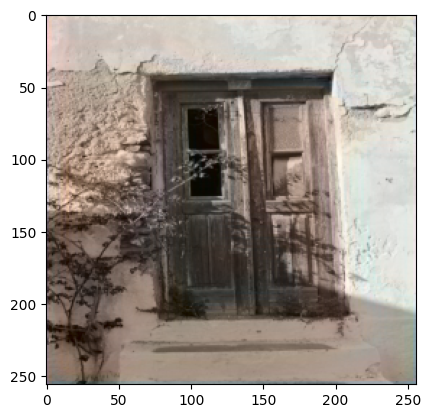

In [ ]:
plt.imshow(rgb_test)

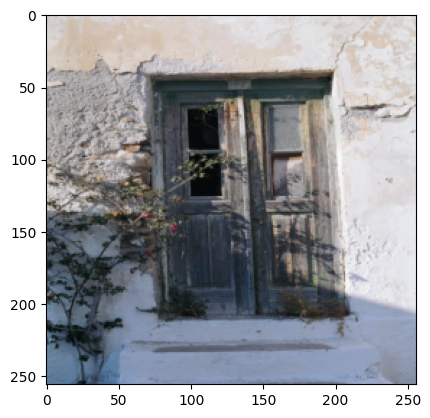

In [ ]:
ab = test_ab.permute(1,2,0).cpu().numpy()
rgb_test = lab_to_rgb(test_l_enc,ab)
plt.imshow(rgb_test)